In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

import random
import time
from collections import defaultdict

#from windy_gridworld_env import WindyGridWorldEnv
#from windy_gridworld_random_reward_env import WindyGridWorldRandomRewardEnv
#from stoch_windy_gridworld_env import StochWindyGridWorldEnv
#from stoch_windy_gridworld_random_reward_env import StochWindyGridWorldRandomRewardEnv

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

EPS = float(np.finfo(np.float32).eps)

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

In [21]:
#from windy_gridworld_env import WindyGridWorldEnv

In [2]:
#from cliff import CliffWalkingEnv
#from gridworld import GridworldEnv
from cliff import CliffWalkingEnv
from gridworld import GridworldEnv
from windy_gridworld_env import WindyGridWorldEnv

In [3]:
#envs = [CliffWalkingEnv(), GridworldEnv()]
envs = [CliffWalkingEnv(), GridworldEnv(), WindyGridWorldEnv()]
names = ['cliff', 'gridworld', 'windy_gw']
env = envs[0]

In [4]:
#envs = [WindyGridWorldEnv()]
#names = ['windy_gridworld_env']

In [5]:
#envs = [WindyGridWorldEnv(), WindyGridWorldRandomRewardEnv(), StochWindyGridWorldEnv(), StochWindyGridWorldRandomRewardEnv()]
#names = ['windy_gridworld', 'windy_gridworld_r', 'windy_gridworld_s', 'windy_gridworld_s_r']

#env = envs[0]

In [6]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    """
    def policy_fn(observation):
        return int(np.random.rand() * nA) if np.random.rand() < epsilon else np.argmax(Q[observation])
    return policy_fn

100%|██████████| 1000/1000 [00:36<00:00, 27.53it/s]


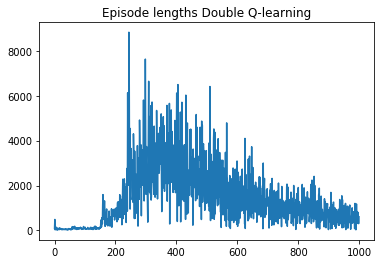

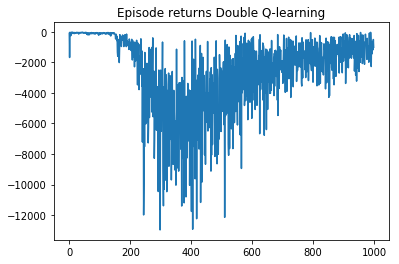

In [7]:
# def avg_Q_vals(env, Q1,Q2):
 
#   Q1_avg_Q2 = defaultdict(lambda: np.zeros(env.action_space.n)) # Needed for policy
#   for key, value in Q1.items():
#         Q1_avg_Q2[key] = (Q1[key] + Q2[key])/2

#   return Q1_avg_Q2

def double_q_learning(env, num_episodes, discount_factor=1.0, epsilon=0.1, alpha_polynom = True):
    """
    Double Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function
    # A nested dictionary that maps state -> (action -> action-value).
    Q1 = defaultdict(lambda: np.zeros(env.action_space.n))
    n_Q1 = defaultdict(lambda: np.zeros(env.action_space.n) + 1)
    Q2 = defaultdict(lambda: np.zeros(env.action_space.n))
    n_Q2 = defaultdict(lambda: np.zeros(env.action_space.n) + 1)
    Q1_avg_Q2 = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q1_avg_Q2, epsilon, env.action_space.n)

    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        s = env.reset()
        done = False
        while not done:
            a = policy(s)
            new_s, r, done, _ = env.step(a)
            R += r
            coin_toss = random.randint(0, 1)
            if (coin_toss == 0):
              if alpha_polynom: 
                alpha = 1 / (n_Q1[s][a]**0.8)
              else:
                alpha = 0.5
              Q1[s][a] = Q1[s][a] + alpha * (r + discount_factor * Q2[new_s][np.argmax(Q1[new_s])] - Q1[s][a]) if not done else Q1[s][a] + alpha * (r - Q1[s][a])
              n_Q1[s][a] += 1
            else:
              if alpha_polynom:  
                  alpha = 1 / (n_Q2[s][a]**0.8)
              else:
                alpha = 0.5
              Q2[s][a] = Q2[s][a] + alpha * (r + discount_factor * Q1[new_s][np.argmax(Q2[new_s])] - Q2[s][a]) if not done else Q2[s][a] + alpha * (r - Q2[s][a])
              n_Q2[s][a] += 1
            
            #Q1_avg_Q2[s][a] = np.maximum(Q1[s][a], Q2[s][a])
            Q1_avg_Q2[s][a] = (Q1[s][a] + Q2[s][a]) / 2
            s = new_s
            i += 1
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    #return Q1_avg_Q2, (episode_lengths, episode_returns)
    return Q1_avg_Q2, (episode_lengths, episode_returns)

Double_q_learning, (episode_lengths_double_q_learning, episode_returns_double_q_learning) = double_q_learning(env, 1000)

# We will help you with plotting this time
plt.plot(episode_lengths_double_q_learning)
plt.title('Episode lengths Double Q-learning')
plt.show()
plt.plot(episode_returns_double_q_learning)
plt.title('Episode returns Double Q-learning')
plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 1319.31it/s]


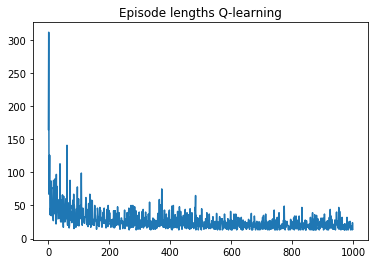

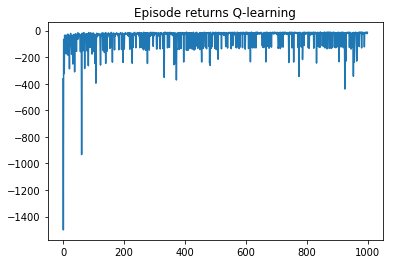

In [8]:
def q_learning(env, num_episodes, discount_factor=1.0, epsilon=0.1, alpha_polynom = True, Q=None, n_Q=None):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    if n_Q is None:
        n_Q = defaultdict(lambda: np.zeros(env.action_space.n) + 1)
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        s = env.reset()
        done = False
        while not done:
            a = policy(s)
            new_s, r, done, _ = env.step(a)
                          
            R += r
            if alpha_polynom:
                alpha = 1 / (n_Q[s][a]**0.8)
            else:
                alpha = 0.5
            Q[s][a] = Q[s][a] + alpha * (r + discount_factor * np.max(Q[new_s]) - Q[s][a]) if not done else Q[s][a] + alpha * (r - Q[s][a])
            n_Q[s][a] += 1
            s = new_s
            i += 1
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, 1000)

# We will help you with plotting this time
plt.plot(episode_lengths_q_learning)
plt.title('Episode lengths Q-learning')
plt.show()
plt.plot(episode_returns_q_learning)
plt.title('Episode returns Q-learning')
plt.show()

100%|██████████| 2000/2000 [00:00<00:00, 3237.79it/s]
/Users/mefkov/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/mefkov/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


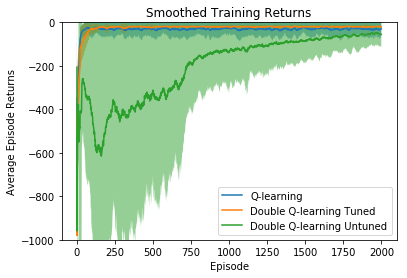

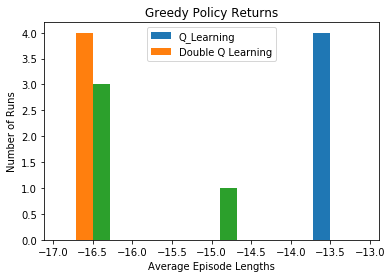

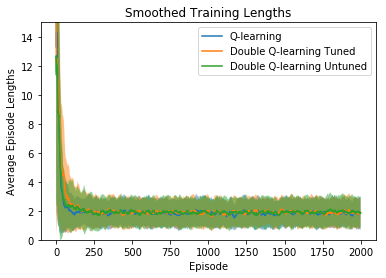

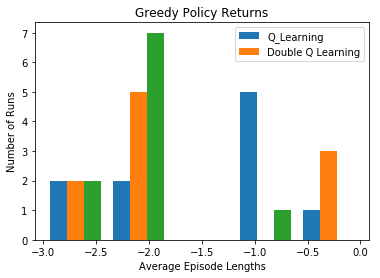

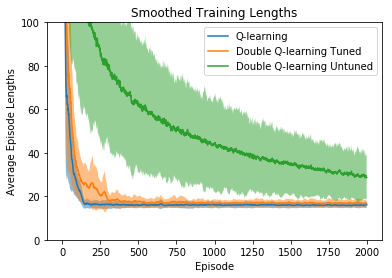

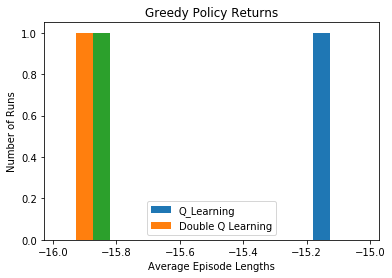

In [33]:
def sample_returns(policy, nr_iter=1):
    rewards = []
    for i in range(nr_iter):
      R = 0
      s = env.reset()
      done = False
      i = 0
      while not done:
          i+=1
          if i > 10000:
            raise Exception("ERROR")
          a = policy(s)
          new_situation = env.step(a)
          R += new_situation[1]
          done = new_situation[2]
          s = new_situation[0]
      rewards.append(R)
    return i, np.average(R)

  
n_runs = 10
n_episodes = 2000
n_samples = 1

n_average = 20

outfolder = os.path.join(os.getcwd(), 'out')

if not os.path.exists(outfolder):
  os.makedirs(outfolder)
  
  

for env, name in zip(envs, names): 

  f = open(os.path.join(outfolder, name + '.txt'), 'w+')

  double_q_learning_lengths, q_learning_lengths, double_q_learning_lengths_polynom = [], [], []
  sampled_double_q_learning_lengths, sampled_double_q_learning_lengths_polynom, sampled_q_learning_lengths = [], [], []
  for i in range(n_runs):
      np.random.seed(i)
      #Q_double_q_learning, (_, episode_returns_double_q_learning) = double_q_learning(env, n_episodes, epsilon = 0.1, alpha_polynom = False)
      #Q_double_q_learning_polynom, (_, episode_returns_double_q_learning_polynom) = double_q_learning(env, n_episodes, epsilon = 0.1, alpha_polynom = True)
      #Q_q_learning, (_, episode_returns_q_learning) = q_learning(env, n_episodes, epsilon = 0.1, alpha_polynom = False)
      
      Q_double_q_learning, (_, episode_returns_double_q_learning) = double_q_learning(env, n_episodes, epsilon = 0.05, alpha_polynom = False)
      Q_double_q_learning_polynom, (_, episode_returns_double_q_learning_polynom) = double_q_learning(env, n_episodes, epsilon = 0.05, alpha_polynom = True)
      Q_q_learning, (_, episode_returns_q_learning) = q_learning(env, n_episodes, epsilon = 0.05, alpha_polynom = False)
      #Q_q_learning_polynom, (_, episode_returns_q_learning_polynom) = q_learning(env, n_episodes, epsilon = 0.05, alpha_polynom = True)
 
      episode_lengths_double_q_learning_polynom = episode_returns_double_q_learning_polynom
      episode_lengths_double_q_learning  =  episode_returns_double_q_learning
      episode_lengths_q_learning  =  episode_returns_q_learning 
      #episode_lengths_q_learning_polynom  =  episode_returns_q_learning_polynom 

      double_q_learning_lengths.append(episode_lengths_double_q_learning)
      double_q_learning_lengths_polynom.append(episode_lengths_double_q_learning_polynom)
      q_learning_lengths.append(episode_lengths_q_learning)
      #q_learning_lengths_polynom.append(episode_lengths_q_learning_polynom)

      policy_double_q_learning_polynom =  make_epsilon_greedy_policy(Q_double_q_learning_polynom, 0, env.action_space.n)
      policy_double_q_learning =  make_epsilon_greedy_policy(Q_double_q_learning, 0, env.action_space.n)
      policy_q_learning = make_epsilon_greedy_policy(Q_q_learning, 0, env.action_space.n)
      #policy_q_learning_polynom = make_epsilon_greedy_policy(Q_q_learning_polynom, 0, env.action_space.n)

      try:
        q_learning_return = sample_returns(policy_q_learning, n_samples)[1]
        #q_learning_return_polynom = sample_returns(policy_q_learning_polynom, n_samples)[1]
        double_q_learning_return = sample_returns(policy_double_q_learning, n_samples)[1]
        double_q_learning_return_polynom = sample_returns(policy_double_q_learning_polynom, n_samples)[1]
        
      except:
        #print("You screwed up")
        continue

      sampled_q_learning_lengths.append(q_learning_return)
      #sampled_q_learning_lengths_polynom.append(q_learning_return_polynom) 
      sampled_double_q_learning_lengths.append(double_q_learning_return)
        
      sampled_double_q_learning_lengths_polynom.append(double_q_learning_return_polynom)  





  episode_lengths_double_q_learning_average = np.average(double_q_learning_lengths, 0)
  episode_lengths_double_q_learning_std = np.std(double_q_learning_lengths, 0)
    
  episode_lengths_double_q_learning_average_polynom = np.average(double_q_learning_lengths_polynom, 0)
  episode_lengths_double_q_learning_std_polynom = np.std(double_q_learning_lengths_polynom, 0)
    
  episode_lengths_q_learning_average = np.average(q_learning_lengths, 0)
  episode_lengths_q_learning_std = np.std(q_learning_lengths, 0)
    
  #episode_lengths_q_learning_average_polynom = np.average(q_learning_lengths_polynom, 0)

  episode_lengths_double_q_learning_n_average = []
  episode_lengths_double_q_learning_n_std = []
  
  for i in range(len(episode_lengths_double_q_learning_average)):
      if i - n_average + 1 >= 0:
          episode_lengths_double_q_learning_n_average.append(np.average(episode_lengths_double_q_learning_average[i-n_average+1:i+1]))  
          episode_lengths_double_q_learning_n_std.append(np.average(episode_lengths_double_q_learning_std[i-n_average+1:i+1]))  
            
      else:
          episode_lengths_double_q_learning_n_average.append(np.average(episode_lengths_double_q_learning_average[0:i+1]))
          episode_lengths_double_q_learning_n_std.append(np.average(episode_lengths_double_q_learning_std[0:i+1]))
            



  episode_lengths_q_learning_n_average = []
  episode_lengths_q_learning_n_std = []
  for i in range(len(episode_lengths_q_learning_average)):
      if i - n_average + 1 >= 0:
          episode_lengths_q_learning_n_average.append(np.average(episode_lengths_q_learning_average[i-n_average+1:i+1]))
          episode_lengths_q_learning_n_std.append(np.average(episode_lengths_q_learning_std[i-n_average+1:i+1]))
      
      else:
          episode_lengths_q_learning_n_average.append(np.average(episode_lengths_q_learning_average[0:i+1]))
          episode_lengths_q_learning_n_std.append(np.average(episode_lengths_q_learning_std[0:i+1]))
  '''          
  episode_lengths_q_learning_n_average_polynom = []
  for i in range(len(episode_lengths_q_learning_average_polynom)):
      if i - n_average + 1 >= 0:
          episode_lengths_q_learning_n_average_polynom.append(np.average(episode_lengths_q_learning_average_polynom[i-n_average+1:i+1]))
      else:
          episode_lengths_q_learning_n_average_polynom.append(np.average(episode_lengths_q_learning_average_polynom[0:i+1]))
  '''

  episode_lengths_double_q_learning_n_average_polynom = []
  episode_lengths_double_q_learning_n_std_polynom = []
  for i in range(len(episode_lengths_double_q_learning_average_polynom)):
      if i - n_average + 1 >= 0:
          episode_lengths_double_q_learning_n_average_polynom.append(np.average(episode_lengths_double_q_learning_average_polynom[i-n_average+1:i+1]))  
          episode_lengths_double_q_learning_n_std_polynom.append(np.average(episode_lengths_double_q_learning_std_polynom[i-n_average+1:i+1]))  
      
      else:
          episode_lengths_double_q_learning_n_average_polynom.append(np.average(episode_lengths_double_q_learning_average_polynom[0:i+1]))
          episode_lengths_double_q_learning_n_std_polynom.append(np.average(episode_lengths_double_q_learning_std_polynom[0:i+1]))
  
            
            

  plt.figure()
  if name != 'cliff':
        episode_lengths_q_learning_n_average = -np.array(episode_lengths_q_learning_n_average)
        episode_lengths_double_q_learning_n_average_polynom = -np.array(episode_lengths_double_q_learning_n_average_polynom)
        episode_lengths_double_q_learning_n_average = -np.array(episode_lengths_double_q_learning_n_average)
        
  t = np.arange(n_episodes)
  plt.plot(episode_lengths_q_learning_n_average)
  #plt.plot(episode_lengths_q_learning_n_average_polynom)
  plt.plot(episode_lengths_double_q_learning_n_average)
  plt.plot(episode_lengths_double_q_learning_n_average_polynom)
  plt.fill_between(t, np.array(episode_lengths_q_learning_n_average) - np.array(episode_lengths_q_learning_n_std), np.array(episode_lengths_q_learning_n_average) + np.array(episode_lengths_q_learning_n_std), alpha=0.5, label='1 sigma range')
  plt.fill_between(t, np.array(episode_lengths_double_q_learning_n_average) - np.array(episode_lengths_double_q_learning_n_std), np.array(episode_lengths_double_q_learning_n_average) + np.array(episode_lengths_double_q_learning_n_std), alpha=0.5, label='1 sigma range')
  plt.fill_between(t, np.array(episode_lengths_double_q_learning_n_average_polynom) - np.array(episode_lengths_double_q_learning_n_std_polynom), np.array(episode_lengths_double_q_learning_n_average_polynom) + np.array(episode_lengths_double_q_learning_n_std_polynom), alpha=0.5, label='1 sigma range')
 
  #,label="Double Q-learning Tuned")
  #,label="Double Q-learning Untuned")
  #plt.legend()  
    
    
  axes = plt.gca()
  if name == 'cliff':
    axes.set_ylim([-1000, 0])
  elif name == 'gridworld':
    axes.set_ylim([0, 15])
  elif name == 'windy_gw':
    axes.set_ylim([0, 100])
  #axes.set_ylim([10, 200])
  axes.legend(['Q-learning', 'Double Q-learning Tuned', 'Double Q-learning Untuned'])
  plt.xlabel("Episode")
  if name!='cliff':  
      plt.ylabel("Average Episode Lengths")
      plt.title("Smoothed Training Lengths")
  else:
    plt.ylabel("Average Episode Returns")
    plt.title("Smoothed Training Returns")
  plt.savefig(os.path.join(outfolder, name + "_training.png"))


  f.write("Double Q Learning : " + str(sampled_double_q_learning_lengths) + "\n")
  f.write("Q-learning: " + str(sampled_q_learning_lengths) + "\n")
  f.write("Double Q Learning Mean : " + str(np.array(sampled_double_q_learning_lengths).mean()) + "\n")
  f.write("Q-Learning Mean : " + str(np.array(sampled_q_learning_lengths).mean()) + "\n")

  plt.figure()
  plt.hist([sampled_q_learning_lengths, sampled_double_q_learning_lengths, sampled_double_q_learning_lengths_polynom], bins=5)
  plt.legend(['Q_Learning', 'Double Q Learning'])
  plt.xlabel("Average Episode Lengths")
  plt.ylabel("Number of Runs")
  plt.title("Greedy Policy Returns")
  plt.savefig(os.path.join(outfolder, name + "_samples.png"))

  from scipy.stats import ttest_ind
  f.write("The result from an independent t-test are as follows.\n")
  f.write(str(ttest_ind(sampled_q_learning_lengths, sampled_double_q_learning_lengths)) + "\n")
  f.close()